In [1]:
"""
This is a demo of the findings in the paper:
Language Models Implement Simple Word2Vec-Style Vector Arithmetic
and will run through the main result, which is that while solving some task,
e.g, recalling the capital city of some location, a language model 
(GPT2-medium in this case) will predict that city by transforming the country name
into the capital with an additive update:
Poland+o_city=Warsaw
and that the exact vector the model infers to do this (o_city) implements the same
function on other examples when we add it to the residual stream of the forward
pass, e.g., China+o_cirt=Beijing
"""

'\nThis is a demo of the findings in the paper:\nLanguage Models Implement Simple Word2Vec-Style Vector Arithmetic\nand will run through the main result, which is that while solving some task,\ne.g, recalling the capital city of some location, a language model \n(GPT2-medium in this case) will predict that city by transforming the country name\ninto the capital with an additive update:\nPoland+o_city=Warsaw\nand that the exact vector the model infers to do this (o_city) implements the same\nfunction on other examples when we add it to the residual stream of the forward\npass, e.g., China+o_cirt=Beijing\n'

In [2]:
from modeling import *
import matplotlib.pyplot as plt

In [3]:
model, tokenizer = load_gpt2('gpt2-medium')

In [4]:
model = model.float()

In [5]:
wrapper = GPT2Wrapper(model, tokenizer)


In [6]:
def tokenize(text):
    inp_ids = wrapper.tokenize(text)
    str_toks = wrapper.list_decode(inp_ids[0])
    return inp_ids, str_toks

In [7]:
poland_text="""Q: What is the capital of France?
A: Paris
Q: What is the capital of Poland?
A:"""

poland_ids, pol_toks = tokenize(poland_text)

In [8]:
logits = wrapper.get_layers(poland_ids)
wrapper.print_top(logits[1:]) #skip the embedding layer

0  ( [ The:,
 at and Act A
1  A The ( [ Is59
 At and40
2  A [ ( The At Is Act at59,
3  A [ ( Act At Is The CH An at
4  A [ At Q (Q The Are M An
5  A M No At The payable Q Qu (Q
6  No M A The C Die An H En Qu
7  C A No The M n P N H An
8  A The C P H No n Ass N T
9  A C No nil The Ch P An H N
10  A The G C N P No Me An Le
11  A C N None P G The Pr Ce H
12  Unknown None C G A N Bar The Ch P
13  C P N G B A Unknown St None The
14  St N G P Poland B C Pol A D
15  Poland P St Pol Warsaw Polish N B G Germany
16  Poland Warsaw Polish Poles Budapest Prague Pol Germany Berlin Moscow
17  Poland Warsaw Polish Poles Budapest Prague � Pol Lithuania Moscow
18  Poland Warsaw Polish Prague Budapest Poles Moscow � Berlin Kiev
19  Warsaw Poland Polish Budapest Prague Moscow Berlin Kiev � Frankfurt
20  Warsaw Poland Prague Budapest Polish Moscow Kiev Berlin Frankfurt Brussels
21  Warsaw Poland Polish Prague Budapest � Kiev Sz Berlin Moscow
22  Warsaw Poland Prague Budapest K W Kiev Sz Moscow Berlin
23  W

In [9]:
"""
We can decode at the residual stream between the attention and FFN to show that 
it is the FFN update that updates from Poland to Warsaw, but a slightly easier way to do this is to
subtract the FFN update that was applied at layer 19 to show the intermediate residual stream state
(i.e., between the attention and FFN)
"""

wrapper.add_hooks()
out = wrapper.model(input_ids = poland_ids, output_hidden_states=True) #run it again to activate hooks
logits = out.logits
hidden_states = out.hidden_states
hidden_states = list(hidden_states)[1:] #skip the embedding layer to stay consistent with our indexing

#get the FFN output update at layer 19
o_city = wrapper.model.activations_['mlp_19']


print(len(hidden_states)) #24

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
print("Original top tokens at layer 19")
wrapper.print_top(layer_logits[19].unsqueeze(0))

hidden_states[19]-=o_city 


layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
print("After subtracting mlp_19 (o_city)")
wrapper.print_top(layer_logits[19].unsqueeze(0))

#Now we can see that the prediction at layer 19 has gone from Warsaw to Poland

24
Original top tokens at layer 19
0  Warsaw Poland Polish Budapest Prague Moscow Berlin Kiev � Frankfurt
After subtracting mlp_19 (o_city)
0  Poland Warsaw Polish Budapest Prague Poles � Moscow Berlin Kiev


In [10]:
"""
before showing that mlp_19 promotes capital cities in general, we can show that mlp_19 can interact with other layers
within the same input

We can use o_city to manipulate the other layers that are either in argument formation (representing " Poland")
or in saturation (representing " Warsaw"). We can try to flip these states so that all of the arguments become
the output " Warsaw" and the saturated states go back to the argument " Poland"

""" 

out = wrapper.model(input_ids = poland_ids, output_hidden_states=True) #run it again to activate hooks
logits = out.logits
hidden_states = out.hidden_states
hidden_states = list(hidden_states)[1:]

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)

print("Original: most likely tokens starting at layer 15:")
wrapper.print_top(layer_logits[15:])

print("----")
#We can add o_city to go from Poland to Warsaw, and subtract to go from Warsaw to Poland

#We find that when we intervene at a single later layer (>19), we have to scale the vector up
#and for some reason, it tends to need to scale down at the last layer
#in the paper, this is partly why we apply the interventions at multiple layers in a row, so that
#it accumulates in the forward pass.
hidden_states[15]+=o_city
hidden_states[16]+=o_city
hidden_states[17]+=o_city
hidden_states[18]+=o_city
hidden_states[19]-=o_city 
hidden_states[20]-=2*o_city 
hidden_states[21]-=3*o_city
hidden_states[22]-=4*o_city 
hidden_states[23]-=.9*o_city #The last layer can be weird. Play around with this scaling factor to see

layer_logits = wrapper.layer_decode(hidden_states)
layer_logits = torch.stack(layer_logits).squeeze(-1)
#As you can see, we can flip every token from Warsaw to Poland or vice versa 
#except for layer 15 with +/- o_city, with some scaling for the later layers
print("After intervention: Most likely tokens starting at layer 15:")
wrapper.print_top(layer_logits[15:])

Original: most likely tokens starting at layer 15:
0  Poland P St Pol Warsaw Polish N B G Germany
1  Poland Warsaw Polish Poles Budapest Prague Pol Germany Berlin Moscow
2  Poland Warsaw Polish Poles Budapest Prague � Pol Lithuania Moscow
3  Poland Warsaw Polish Prague Budapest Poles Moscow � Berlin Kiev
4  Warsaw Poland Polish Budapest Prague Moscow Berlin Kiev � Frankfurt
5  Warsaw Poland Prague Budapest Polish Moscow Kiev Berlin Frankfurt Brussels
6  Warsaw Poland Polish Prague Budapest � Kiev Sz Berlin Moscow
7  Warsaw Poland Prague Budapest K W Kiev Sz Moscow Berlin
8  Warsaw W K Br Po B L Z P Poland
----
After intervention: Most likely tokens starting at layer 15:
0  Poland St P Warsaw Moscow Pol Vienna Berlin B Prague
1  Warsaw Poland Polish Budapest Prague Moscow Vienna Berlin Pol Brussels
2  Warsaw Poland Polish Budapest Prague Moscow � Vienna Berlin Pol
3  Warsaw Poland Prague Budapest Polish Moscow Berlin Vienna Kiev �
4  Poland Warsaw Polish Budapest Prague Poles � Moscow B

In [11]:
"""
Next we will show that o_city works to promote other capital cities in totally different contexts
e.g., transforming China into Beijing where the context does not cue the model that Beijing might be important

We will perform the o vector intervention described in the paper, in which we replace FFN blocks entirely,
substituting their updates with the precomputed o vector (in this case o_city)
"""

#first we will store the normal FFN layers so that we can restore the model later
mlps = []
for i in range(len(wrapper.model.transformer.h)):
    mlps.append(wrapper.model.transformer.h[i].mlp)
    
def reset_mlps():
    for i in range(len(wrapper.model.transformer.h)):
        wrapper.model.transformer.h[i].mlp = mlps[i]
        





In [12]:
#start the intervention at layer 18 and apply it to all of the following layers
layer_idx = 18

def o_intervention(o_func, layer_idx):
    for i in range(layer_idx,24): #Note: change these to change which layers are intervened on
        wrapper.model.transformer.h[i].mlp = LambdaLayer(lambda x: o_func) #instead of outputting FFN(x), output o_func
    

In [13]:
"""
First, let's show what we are trying to do:
given some repeating pattern of random tokens with some subject token mixed in, we
can take advantage of the fact that when predicting the next instance of the subject token,
the model will represent that subject token in some middle layer, giving us a chance to intervene
"""

china_text = "table mug free China table mug free China table mug free"
reset_mlps()
china_ids, china_toks = tokenize(china_text)
cntrl_china_logits = wrapper.get_layers(china_ids)
#Let's just look at the most likely token per layer to make it clear
wrapper.print_top(cntrl_china_logits, k=1)
#as you can see, the prediction is already China by layer 15, we can introduce an intervention to add o_city to some
#range of these layers to try to transform it into Beijing
#we will essentially perform the operation China+o_city=Beijing
#where o_city is the FFN update that had originally transformed Poland into Warsaw

0  free
1  flowing
2 bies
3 bies
4 bies
5 bies
6 bies
7 bies
8 bies
9 bies
10  American
11  American
12  Hy
13  Java
14 

15  China
16  China
17  China
18  China
19  China
20  China
21  China
22  China
23  China
24  China


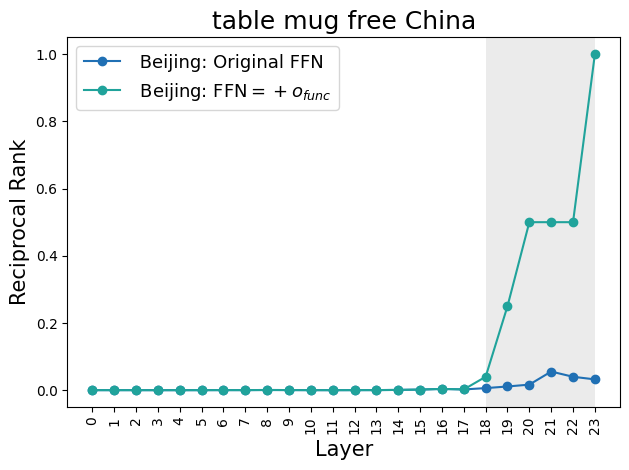

In [14]:
#For this result we will plot the reciprocal ranks of the tokens we are interested in within the vocab distributions
#These tokens are the original country (argument: China) and the corresponding capital (output: Beijing)

def plot_rrs_before_and_after_intervention(before_rrs, after_rrs, title, label, line_idx=None):
    colors = [
        [0.12710496, 0.44018454, 0.70749712, 1.        ], #Original FFN 
        [0.12710496, 0.64018454, 0.60749712, 1.        ], #FFN$=+o_{func}$
    ]
    plt.title(title, fontsize=18)
    plt.xticks(np.arange(24), np.arange(24), rotation=90)
    plt.plot(before_rrs[1:], label=f'{label}: Original FFN', marker='o', color=colors[0]) #Why [1:]? rrs[0] is the embedding table step
    plt.plot(after_rrs[1:], label=f'{label}:'+' FFN$=+o_{func}$', marker='o', color=colors[1]) #Why [1:]? rrs[0] is the embedding table step

    if line_idx is not None:
        plt.axvspan(line_idx, 23, facecolor='.92')
    plt.legend(fontsize=13)
    plt.xlabel("Layer", fontsize=15)
    plt.ylabel("Reciprocal Rank", fontsize=15)
    plt.yticks([0.,.2,.4,.6,.8,1.], ['0.0','0.2','0.4','0.6','0.8','1.0'])
    plt.tight_layout()
    #plt.show()


#paper_o_city = torch.tensor(np.load('ovectors/gpt2medium/city_capital_o19_gpt2-medium.npy')).squeeze(0)

cntrl_rrs = wrapper.rr_per_layer(cntrl_china_logits, ' Beijing')

o_intervention(o_city.unsqueeze(0), layer_idx)

interv_china_logits = wrapper.get_layers(china_ids)
interv_rrs = wrapper.rr_per_layer(interv_china_logits, ' Beijing')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, ' '.join(china_text.split()[:4]), " Beijing", line_idx=layer_idx)
#You should see that even on this nonsense input, Beijing gets promoted from very low in the vocab to the top spot
#in the last layer

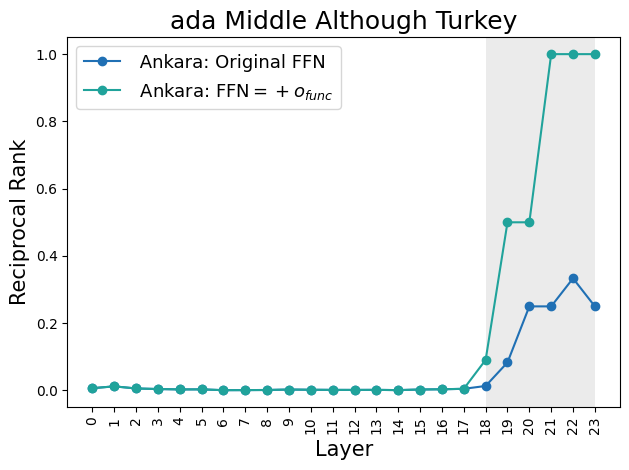

In [15]:
# We can repeat this with other examples as well. It might not always promote to most likely prediction in the last
# layer, but you should virtually always see an increase in the corresponding capital
country_text = f"ada Middle Although Turkey ada Middle Although Turkey ada Middle Although"
def reset_mask(nheads=16):
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask
reset_mlps()
country_ids, country_toks = tokenize(country_text)
cntrl_country_logits = wrapper.get_layers(country_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_country_logits, ' Ankara')

o_intervention(o_city.unsqueeze(0), layer_idx)

interv_country_logits = wrapper.get_layers(country_ids)
interv_rrs = wrapper.rr_per_layer(interv_country_logits, ' Ankara')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, ' '.join(country_text.split()[:4]), " Ankara", line_idx=layer_idx)
plt.savefig('turkey.pdf')



In [16]:
"""
We also find that we can find an update like this that uppercases the first letter of tokens.
In this example, we find that the model uses the in-context ' brown' token to later get the
final answer " Brown"
"""
reset_mlps()
wrapper.add_hooks()
colors_text = """Q: On the floor, I see a silver keychain, a red pair of sunglasses, a gold sheet of paper, a black dog leash, and a blue cat toy. What color is the keychain?
A: Silver
Q: On the table, you see a brown sheet of paper, a red fidget spinner, a blue pair of sunglasses, a teal dog leash, and a gold cup. What color is the sheet of paper?
A:"""


colors_ids, colors_toks = tokenize(colors_text)
colors_logits = wrapper.get_layers(colors_ids)[1:]

#If you were to print out these logits, you would see that it seems like the 
#model never actually goes through argument formation.
#wrapper.print_top(colors_logits)

#However, if we decode at the residual stream right before the FFN update,
#you'll see that it represents ' brown' in only this spot.
#Here we show how to decode at the intermediate residual stream (between attention and FFN)

inter_logits = []
for i in range(len(wrapper.model.transformer.h)):
    inter_logits.append(wrapper.model.activations_['intermediate_residual_'+str(i)])
inter_logits = torch.stack(inter_logits).unsqueeze(1)
inter_logits = torch.stack(wrapper.layer_decode(inter_logits)).squeeze(-1)
print("Intermediate residual at layer 19:")
wrapper.print_top(inter_logits[19].unsqueeze(0))
print("Final hidden state at layer 19:")
wrapper.print_top(colors_logits[19].unsqueeze(0))

#We don't claim that argument formation/function application is used to solve  
#every example, but it's worth mentioning cases where it can occur very briefly
o_upper = wrapper.model.activations_['mlp_19']


Intermediate residual at layer 19:
0  brown Brown white black red blue Black yellow Red purple
Final hidden state at layer 19:
0  Brown brown Black white black Red Yellow Blue White blue


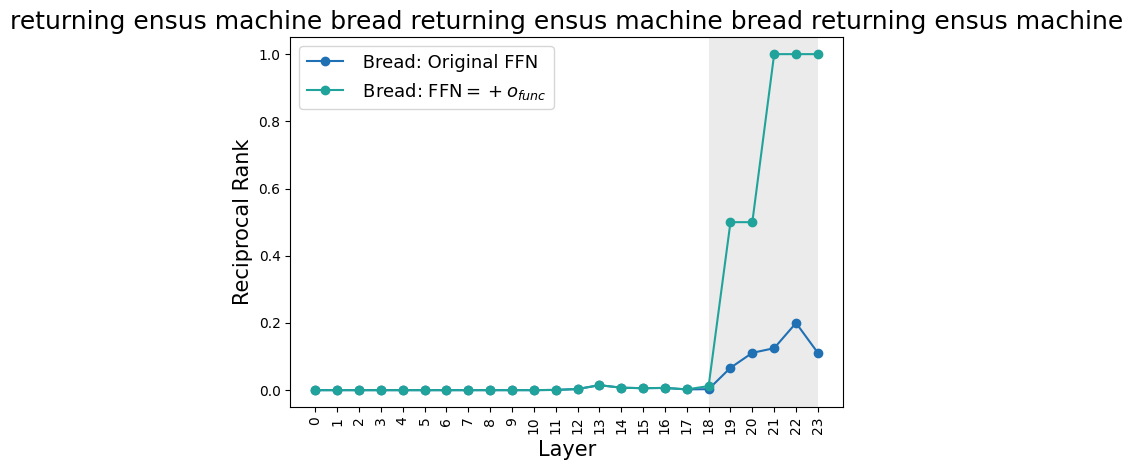

In [17]:
#here we will uppercase a token totally unrelated to the previous context: " bread" to " Bread"

uppper_text = f"returning ensus machine bread returning ensus machine bread returning ensus machine"
def reset_mask(nheads=16):
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask

reset_mlps()
uppper_ids, uppper_toks = tokenize(uppper_text)
cntrl_uppper_logits = wrapper.get_layers(uppper_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_uppper_logits, ' Bread')

o_intervention(o_upper.unsqueeze(0), layer_idx)

interv_uppper_logits = wrapper.get_layers(uppper_ids)
interv_rrs = wrapper.rr_per_layer(interv_uppper_logits, ' Bread')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, uppper_text, " Bread", line_idx=layer_idx)


" Bread" [28731]
" Crouch" [327, 48626] [' C', 'rouch']


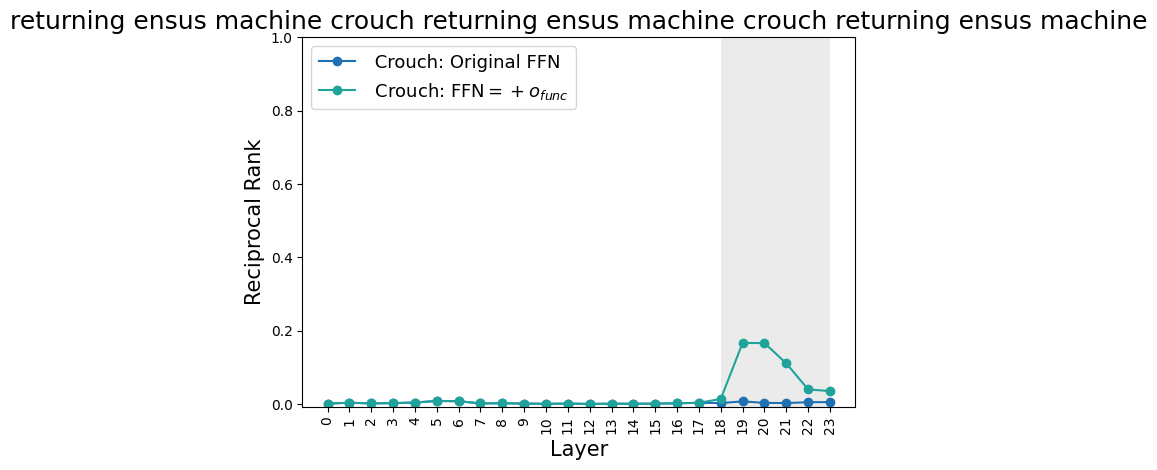

In [18]:
"""
We find that the uppercasing o vector performs the most consistently out of the other two we tested.
One common failure point we saw for all three, however, is when either the argument or output tokens
are broken up into multiple tokens. For example, " crouch" is one token, but the capitalized form " Crouch"
is split into the tokens " C"+"rouch". It would be surprising if the relationship between " crouch" and " C" 
was encoded the same way as e.g., " bread" and " Bread", and we see that cases like these tend to react
more poorly to the intervention. Cases where a token maps to a single capital letter like these are particularly
challenging.
See Appendix E of the paper for an analysis on the effects of tokenization.
"""
tokens_Crouch =wrapper.tokenizer.encode(" Crouch")
print('" Bread"', wrapper.tokenizer.encode(" Bread"))
print('" Crouch"', tokens_Crouch, [wrapper.tokenizer.decode([t]) for t in tokens_Crouch])

uppper_text = f"returning ensus machine crouch returning ensus machine crouch returning ensus machine"
def reset_mask(nheads=16):
    headmask = torch.ones(len(wrapper.model.transformer.h),nheads)
    return headmask

reset_mlps()
uppper_ids, uppper_toks = tokenize(uppper_text)
cntrl_uppper_logits = wrapper.get_layers(uppper_ids)

cntrl_rrs = wrapper.rr_per_layer(cntrl_uppper_logits, ' Crouch')

o_intervention(o_upper.unsqueeze(0), layer_idx)

interv_uppper_logits = wrapper.get_layers(uppper_ids)
interv_rrs = wrapper.rr_per_layer(interv_uppper_logits, ' Crouch')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, uppper_text, " Crouch", line_idx=layer_idx)

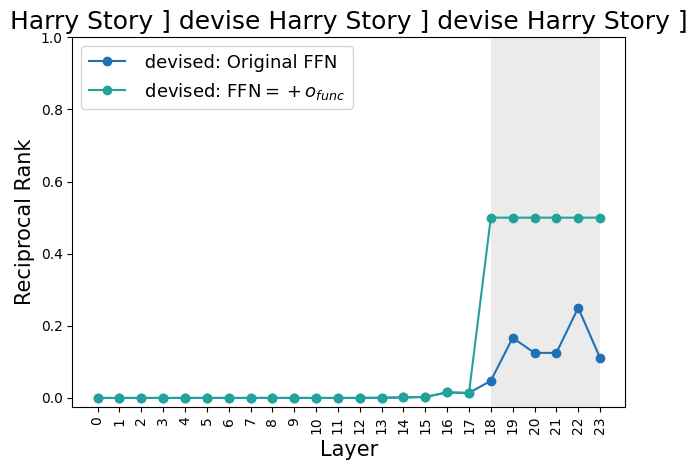

In [19]:
"""
Lastly, we can use a similar update to promote past tense verbs. We find that this update promotes past tensing 
in general, but doesn't promote the past tense verb all the way to to the top of the distribution as often
(only about 8% of the time).
"""
reset_mlps()
pt1 = "Today I abandon. Yesterday I abandoned. Today I abolish. Yesterday I"
pt_ids, pt_toks = tokenize(pt1)
pt_logits=wrapper.get_layers(pt_ids)
o_past = wrapper.model.activations_['mlp_18']

pt_text  = "Harry Story ] devise Harry Story ] devise Harry Story ]"
pt_ids, pt_toks = tokenize(pt_text)

reset_mlps()
cntrl_pt_logits = wrapper.get_layers(pt_ids)
cntrl_rrs = wrapper.rr_per_layer(cntrl_pt_logits, ' devised')

#paper_o_past = torch.tensor(np.load('ovectors/gpt2medium/regular_past_o18_gpt2-medium.npy')).squeeze(0)
o_intervention(o_past.unsqueeze(0), layer_idx)

interv_pt_logits = wrapper.get_layers(pt_ids)
interv_rrs = wrapper.rr_per_layer(interv_pt_logits, ' devised')

plot_rrs_before_and_after_intervention(cntrl_rrs, interv_rrs, pt_text, " devised", line_idx=layer_idx)